In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, Reshape, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input
from tensorflow.keras import Input



In [3]:
data = pd.read_csv('emg_all_features_labeled.csv')

In [4]:
print("Dataset shape:", data.shape)

# Check the column names
print("Column names:", data.columns)

# Display the summary statistics of the dataset
print("Summary statistics:\n", data.describe())

# Check the correlation between columns
correlation = data.corr()
print("Correlation matrix:\n", correlation)

Dataset shape: (6822, 81)
Column names: Index(['0.029437', '0.051465', '0.089432', '0.016893', '0.014127', '0.017735',
       '0.019645', '0.014079', '0.030692', '0.052209', '0.08977', '0.019609',
       '0.016973', '0.020182', '0.021575', '0.017081', '-0.16406', '-0.28906',
       '-0.53906', '-0.054688', '-0.054688.1', '-0.11719', '-0.125',
       '-0.054688.2', '0.09375', '0.16406', '0.3125', '0.03125', '0.039063',
       '0.046875', '0.0625', '0.03125.1', '53', '49', '56', '39', '21', '27',
       '31', '23', '0.074323', '0.11297', '0.21297', '0.050417', '0.039271',
       '0.047031', '0.05099', '0.036354', '0.03125.2', '0.054688', '0.03125.3',
       '0.039063.1', '0.03125.4', '0.046875.1', '0.023438', '0.023438.1',
       '0.017896', '0.02666', '0.04566', '0.013029', '0.010639', '0.011585',
       '0.011896', '0.010152', '4.3672', '6.6563', '11.773', '2.9219',
       '2.3594', '2.6797', '2.8047', '2.3516', '2', '3', '6', '0', '0.1', '1',
       '1.1', '0.2', '1.2'],
      dtype='

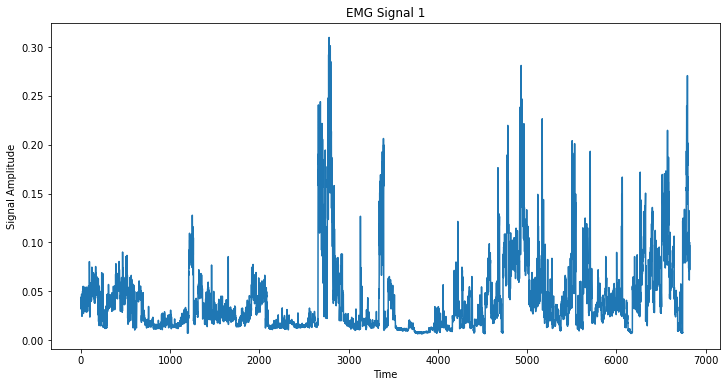

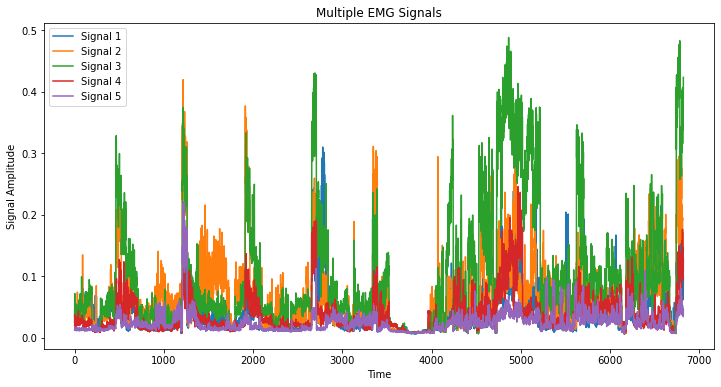

In [7]:
# Plot a single EMG signal
signal_index = 0  # Index of the EMG signal to plot
plt.figure(figsize=(12, 6))
plt.plot(data[data.columns[signal_index]])
plt.xlabel('Time')
plt.ylabel('Signal Amplitude')
plt.title('EMG Signal {}'.format(signal_index+1))
plt.show()

# Plot multiple EMG signals
num_signals_to_plot = 5  # Number of signals to plot
plt.figure(figsize=(12, 6))
for i in range(num_signals_to_plot):
    plt.plot(data[data.columns[i]], label='Signal {}'.format(i+1))
plt.xlabel('Time')
plt.ylabel('Signal Amplitude')
plt.title('Multiple EMG Signals')
plt.legend()
plt.show()


In [8]:
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(data)


In [13]:
def build_generator(latent_dim):
    model = Sequential()
    model.add(Dense(256, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(2048))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(np.prod(data.shape[1:]), activation='tanh'))
    model.add(Reshape(data.shape[1:]))
    return model

def build_discriminator():
    model = Sequential()
    model.add(Flatten(input_shape=data.shape[1:]))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    return model


In [18]:
latent_dim = 100  # Dimensionality of the generator input

discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

generator = build_generator(latent_dim)
z = Input(shape=(latent_dim,))
generated_data = generator(z)
discriminator.trainable = False
validity = discriminator(generated_data)
combined = Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=Adam())


In [20]:
for epoch in range(epochs):
    # Train discriminator
    indices = np.random.randint(0, normalized_data.shape[0], batch_size)
    real_data = normalized_data[indices]
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    generated_data = generator.predict(noise)
    
    discriminator_loss_real = discriminator.train_on_batch(real_data, real)
    discriminator_loss_fake = discriminator.train_on_batch(generated_data, fake)
    discriminator_loss = 0.5 * np.add(discriminator_loss_real, discriminator_loss_fake)
    
    # Train generator
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    generator_loss = combined.train_on_batch(noise, real)
    
    # Print progress
    if epoch % 1000 == 0:
        print(f"Epoch: {epoch}/{epochs}, Discriminator Loss: {discriminator_loss[0]}, Generator Loss: {generator_loss}")

1/1 [==============================] - 0s 331ms/step
Epoch: 0/20000, Discriminator Loss: 0.7573930621147156, Generator Loss: 0.6976867914199829
1/1 [==============================] - 0s 75ms/step
Epoch: 1000/20000, Discriminator Loss: 7.838960931039196e-06, Generator Loss: 21.36737060546875
1/1 [==============================] - 0s 71ms/step
Epoch: 2000/20000, Discriminator Loss: 1.4097329277262816e-06, Generator Loss: 21.270164489746094
1/1 [==============================] - 0s 402ms/step
Epoch: 3000/20000, Discriminator Loss: 1.3992888270308868e-07, Generator Loss: 24.268409729003906
1/1 [==============================] - 0s 72ms/step
Epoch: 4000/20000, Discriminator Loss: 4.019034904878538e-08, Generator Loss: 26.20191192626953
1/1 [==============================] - 0s 74ms/step
Epoch: 5000/20000, Discriminator Loss: 3.562785694244397e-08, Generator Loss: 28.43015480041504
1/1 [==============================] - 0s 81ms/step
Epoch: 6000/20000, Discriminator Loss: 1.843831833872253e-0

In [21]:
num_samples = 10  # Number of fake signals to generate

noise = np.random.normal(0, 1, (num_samples, latent_dim))
generated_signals = generator.predict(noise)

# Rescale generated signals to their original range
generated_signals = scaler.inverse_transform(generated_signals)


1/1 [==============================] - 1s 552ms/step
